In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm

RANDOM_STATE = 2004
DATA_DIR = Path('datasets/luad_tcga_gdc')
TPM_FILE = DATA_DIR / 'data_mrna_seq_tpm.txt'
MUT_FILE = DATA_DIR / 'data_mutations.txt'
CNA_FILE = DATA_DIR / 'data_cna.txt'

TOP_VAR_GENES      = 1_000      # оставляем 1000 самых вариабельных генов
MIN_MUT_FREQ       = 0.05       # ≥ 5 % пациентов
MIN_CNA_FREQ       = 0.05       # ≥ 5 % пациентов
CNA_GAIN_THRESHOLD =  2         # амплификация = +2
CNA_LOSS_THRESHOLD = -2         # глубокая делеция = −2
PCA_VARIANCE_THR   = 0.90       # хотим 90 % объяснённой дисперсии

In [13]:
def load_expression(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0, sep='\t', comment='#')
    df = df.drop(columns=[c for c in ('Entrez_Gene_Id', 'EntrezGeneId') if c in df.columns])
    df = np.log2(df + 1).T                            # строки → образцы
    top = df.var().nlargest(TOP_VAR_GENES).index
    df  = df[top]
    return (df - df.mean()) / df.std(ddof=0)          # z-score

expr_df = load_expression(TPM_FILE)
expr_z  = pd.DataFrame(StandardScaler().fit_transform(expr_df),
                       index=expr_df.index, columns=expr_df.columns)
expr_z.shape

(518, 1000)

In [14]:
def load_mutations(path: Path) -> pd.DataFrame:
    usecols = ['Tumor_Sample_Barcode', 'Hugo_Symbol', 'Variant_Classification']
    mut = pd.read_csv(path, sep='\t', usecols=usecols, comment='#')
    mut = mut[mut['Variant_Classification'] != 'Silent']
    mut['Sample'] = (
        mut['Tumor_Sample_Barcode'].str.slice(stop=12)   # TCGA-XX-YYYY
                             .str.replace(r'[A-Za-z]$', '', regex=True)
    )
    mat = pd.crosstab(mut['Sample'], mut['Hugo_Symbol']).clip(upper=1)
    mat = mat.loc[:, mat.mean() >= MIN_MUT_FREQ]
    mat.columns = mat.columns + '_mut'
    return mat

mut_df = load_mutations(MUT_FILE)
mut_df.shape

(518, 741)

In [15]:
def load_cna(path: Path):
    cna = pd.read_csv(path, sep='\t', index_col=0, comment='#')
    cna = cna.drop(columns=[c for c in ('Entrez_Gene_Id', 'EntrezGeneId') if c in cna.columns]).T
    amp  = (cna >= CNA_GAIN_THRESHOLD).astype(int)
    dele = (cna <= CNA_LOSS_THRESHOLD).astype(int)
    amp  = amp.loc[:,  amp.mean()  >= MIN_CNA_FREQ].add_suffix('_amp')
    dele = dele.loc[:, dele.mean() >= MIN_CNA_FREQ].add_suffix('_del')
    return amp, dele

amp_df, del_df = load_cna(CNA_FILE)
amp_df.shape, del_df.shape

((508, 4844), (508, 88))

In [16]:
all_samples = expr_z.index
mut_df = mut_df.reindex(all_samples, fill_value=0)
amp_df = amp_df.reindex(all_samples, fill_value=0)
del_df = del_df.reindex(all_samples, fill_value=0)

combined = pd.concat([expr_z, mut_df, amp_df, del_df], axis=1)
# combined.shape
combined.head()

,6440,51297,5225,6192,653509,2266,7031,2877,729238,2243,...,55958_del,57035_del,6007_del,63951_del,646227_del,646581_del,646609_del,654346_del,80039_del,85347_del
TCGA-05-4244-01A,0.458319,0.277907,-0.381757,0.557794,0.732610,-0.578059,-0.912601,-1.034299,0.727462,-0.916899,...,0,0,0,0,0,0,0,0,0,1
TCGA-05-4249-01A,0.196822,0.034726,-0.288453,1.238646,0.831242,-0.759722,-0.833064,0.608309,0.736196,-0.756469,...,0,1,1,0,0,0,0,0,0,1
TCGA-05-4250-01A,0.316856,-0.994841,-0.086407,-0.954141,0.401256,-0.925624,-0.481595,-0.940603,0.441133,-0.767617,...,0,0,0,0,0,0,0,0,0,1
TCGA-05-4382-01A,-1.516244,-0.619610,-1.484789,1.003660,-2.192200,0.241436,-0.884804,1.115261,-1.839599,0.331663,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4384-01A,1.237615,2.240053,1.212388,1.245028,0.950156,1.740603,-0.093345,1.348399,0.894255,1.628071,...,0,0,0,0,0,0,0,1,1,0


⇒  76 компонентов дают ≥ 90% дисперсии


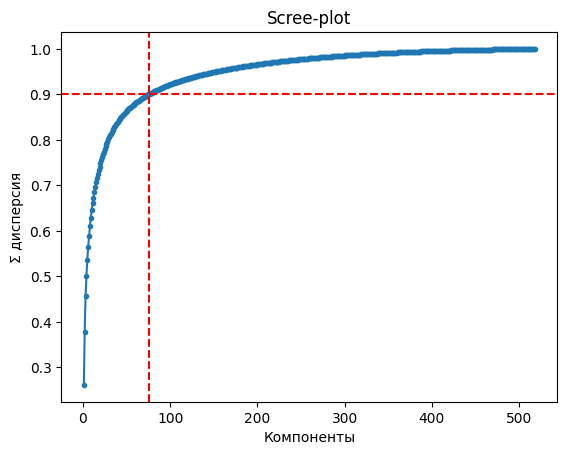

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76
TCGA-05-4244-01A,157.180904,27.770796,-52.538045,6.981269,-30.504276,-20.163922,-15.961320,6.717578,-19.622145,0.967271,...,-1.127122,2.478876,-5.453082,-4.012055,4.338596,4.174996,1.895319,0.097741,3.166019,-5.431470
TCGA-05-4249-01A,110.554269,-73.919521,-45.535707,-23.628148,-13.279726,-2.441255,4.687874,-2.190743,1.301718,-11.493548,...,1.935794,-1.106626,-0.800069,-2.371387,0.619440,0.215626,1.030684,-0.008194,-1.386934,-0.770815
TCGA-05-4250-01A,-14.614978,-2.708734,-0.534406,1.960315,4.821094,23.200166,-10.089275,12.932628,-5.533502,-6.019271,...,9.074273,-2.259327,-1.503829,4.536682,1.607519,-4.152936,2.454581,-3.008797,-2.007834,-1.470552
TCGA-05-4382-01A,-20.311030,-6.499644,-0.146698,-1.642807,0.515931,0.278828,11.558695,-3.396742,-3.482125,-9.906808,...,-0.377336,-0.523015,1.447731,-1.204059,-0.564616,-1.244733,-1.319266,-0.102235,-1.100786,2.130852
TCGA-05-4384-01A,-19.974751,-7.801987,-3.304122,-4.335728,-3.069256,-0.265276,-9.043897,-2.298245,-2.523706,10.796222,...,-3.711985,1.411940,-1.982404,-1.967238,3.044169,2.099663,-1.926449,0.866592,-0.223113,-0.584414


In [17]:
combined.columns = combined.columns.astype(str)
# z-score по каждому признаку
combined_z = StandardScaler().fit_transform(combined)

# PCA без ограничения → ищем минимальное n компонент ≥ PCA_VARIANCE_THR
pca_full = PCA(random_state=RANDOM_STATE).fit(combined_z)
cum_var  = np.cumsum(pca_full.explained_variance_ratio_)
optimal_n = np.searchsorted(cum_var, PCA_VARIANCE_THR) + 1
print(f'⇒  {optimal_n} компонентов дают ≥ {PCA_VARIANCE_THR:.0%} дисперсии')

# визуальная “коленная” кривая
plt.plot(range(1, len(cum_var)+1), cum_var, marker='.')
plt.axhline(PCA_VARIANCE_THR, ls='--', c='r')
plt.axvline(optimal_n,         ls='--', c='r')
plt.xlabel('Компоненты'); plt.ylabel('Σ дисперсия'); plt.title('Scree-plot')
plt.show()

# финальный PCA
pca = PCA(n_components=optimal_n, random_state=RANDOM_STATE)
pcs = pca.fit_transform(combined_z)
pc_df = pd.DataFrame(pcs, index=combined.index,
                     columns=[f'PC{i+1}' for i in range(optimal_n)])
pc_df.head()

In [18]:
def evaluate(model, X):
    """Возвращает (силуэт, labels) либо (-1, None), если <2 кластеров."""
    try:
        if hasattr(model, 'fit_predict'):
            labels = model.fit_predict(X)
        else:                         # GMM
            labels = model.fit(X).predict(X)
    except Exception as e:
        warnings.warn(str(e)); return -1, None
    n_cl = len(np.unique(labels)) - (1 if -1 in labels else 0)
    if n_cl < 2:                      # не годится
        return -1, None
    # для DBSCAN: игнорируем выбросы (-1) в силуэте
    mask = labels != -1
    if mask.sum() < 0.9*len(labels):  # кластеризация «слишком много мусора»
        return -1, None
    score = silhouette_score(X[mask], labels[mask])
    return score, labels

In [19]:
candidates = []

# k-зависимые модели (2…8)
for k in range(2, 9):
    candidates += [
        KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE),
        AgglomerativeClustering(n_clusters=k, linkage='ward'),
        GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE),
        SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=RANDOM_STATE)
    ]

# DBSCAN (k не нужен)
for eps in (0.5, 0.7, 1.0):
    candidates.append(DBSCAN(eps=eps, min_samples=5))

best_score, best_labels, best_model = -1, None, None
for model in candidates:
    score, labels = evaluate(model, pc_df.values)
    if score > best_score:
        best_score, best_labels, best_model = score, labels, model

n_clusters = len(np.unique(best_labels)) - (1 if -1 in best_labels else 0)
print(f'↪  Лучшая модель: {best_model}\n   N clusters = {n_clusters}'
      f'\n   Silhouette = {best_score:.3f}')

labels_final = pd.Series(best_labels, index=pc_df.index, name='Cluster')

↪  Лучшая модель: GaussianMixture(n_components=2, random_state=2004)
   N clusters = 2
   Silhouette = 0.537


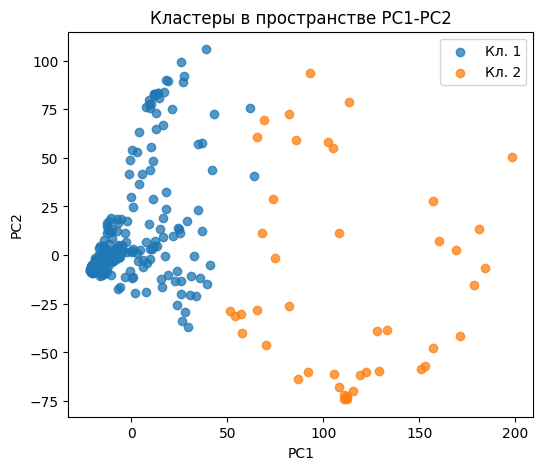

In [20]:
plt.figure(figsize=(6,5))
for lab in np.unique(labels_final):
    idx = labels_final == lab
    plt.scatter(pc_df.loc[idx, 'PC1'], pc_df.loc[idx, 'PC2'],
                label=f'Кл. {lab+1}', alpha=.75)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Кластеры в пространстве PC1-PC2')
plt.legend(); plt.show()

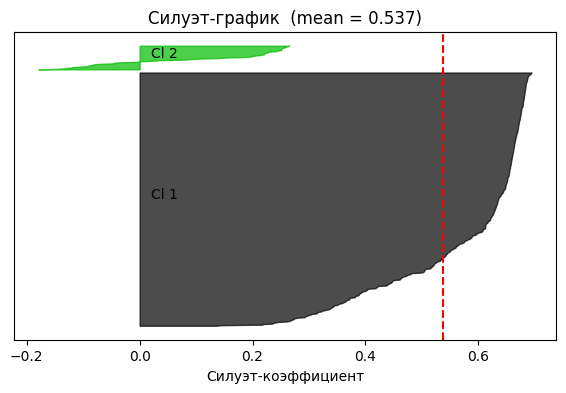

In [21]:
sil_vals = silhouette_samples(pc_df, labels_final)
sil_avg  = silhouette_score(pc_df, labels_final).round(3)
plt.figure(figsize=(7,4))
y_low = 0
for lab in range(n_clusters):
    vals = np.sort(sil_vals[labels_final == lab])
    size = vals.size
    plt.fill_betweenx(np.arange(y_low, y_low+size), 0, vals,
                      color=cm.nipy_spectral(lab/n_clusters), alpha=.7)
    plt.text(0.02, y_low + size/2, f'Cl {lab+1}')
    y_low += size + 5
plt.axvline(sil_avg, c='red', ls='--')
plt.title(f'Силуэт-график  (mean = {sil_avg})')
plt.xlabel('Силуэт-коэффициент'); plt.yticks([])
plt.show()

In [24]:
cl0 = combined.loc[labels_final == 0]
cl1 = combined.loc[labels_final == 1]

diff = (cl1.mean() - cl0.mean()).abs().sort_values(ascending=False)
print(diff.head(20))
print(cl1.head())

83416_amp        0.865633
910_amp          0.845525
913_amp          0.845525
9722_amp         0.845525
100873296_amp    0.845525
79514_amp        0.843411
128371_amp       0.843411
391115_amp       0.843411
646377_amp       0.843411
128368_amp       0.843411
149499_amp       0.843411
128370_amp       0.843411
106479445_amp    0.843411
81474_amp        0.843411
81449_amp        0.843411
115352_amp       0.843411
391112_amp       0.843411
105371455_amp    0.843411
4332_amp         0.843411
81448_amp        0.843411
dtype: float64
                      6440     51297      5225      6192    653509      2266  \
TCGA-05-4244-01A  0.458319  0.277907 -0.381757  0.557794  0.732610 -0.578059   
TCGA-05-4249-01A  0.196822  0.034726 -0.288453  1.238646  0.831242 -0.759722   
TCGA-05-4398-01A -0.128921  0.275457 -0.796785 -0.922422 -0.586154 -0.514265   
TCGA-05-4405-01A  0.849733  0.354035 -0.047477 -0.862288  0.146158 -0.353477   
TCGA-05-4410-01A -0.100296  0.843153 -0.352649  0.916472 -0.17651